In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

In [17]:
L = 2
a = 0.6
P = 6000
E = 200.0*1e9
b = 0.1
h = 0.1
C = 1

In [18]:
Matrix_A = np.array([
    [0, 0, 0, 1, 0, 0],
    [0, 0, L, 0, 0, 1],
    [a, -a, 0, 0, -1, 0],
    [0, (L-a), (a-L), 0, 1, -1],
    [1, -1, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0]
])
Matrix_B = np.array(
    [0, # интеграл при x = 0
     - (12 / (E * b * h**3)*P*(L**3)) / 3, # интеграл при x = L
     12 / (E * b * h**3)*P*a**3 / 3, # условие непрерывности в a
     -12 / (E * b * h**3)*P*a*(L-a)**2/2 + 12 / (E * b * h**3)*P*L*(L-a)**2/2 - 12 / (E * b * h**3)*P*(L-a)**3/6, # условие непрерывности в L-a
     12 / (E * b * h**3) / 2*P*a**2, # условие непрерывности производной в a
     -12 / (E * b * h**3)*P*a*(L-a)+12 / (E * b * h**3)*P*L*(L-a) - 12 / (E * b * h**3)*P*(L-a)**2/2]) # условие непрерывности производной в L-a
coef = np.linalg.solve(Matrix_A, Matrix_B)
coef

array([-0.001512 , -0.00216  , -0.005688 ,  0.       ,  0.0001296,
        0.001776 ])

In [19]:
1/660

0.0015151515151515152

In [20]:
def M(x): # M(x)
    if (x < a):
        return P * x
    elif ((x >= a) and (x < (L-a))):
        return P * a
    else:
        return P * (L - x)
    
def f(x): # f(x)
    return 12 * M(x) / E / b / h**3

In [21]:
def u0(): # краевое условие в 0
    return 0

In [22]:
def uL(): # краевое условие в L
    return 0

In [23]:
def u_exact(x): # точное решение задачи
    if (x < a):
        return coef[0] * x + coef[3] + 12 / (E * b * h**3) * P / 6 * x**3
    elif ((x >= a) and (x < (L-a))):
        return coef[1] * x + coef[4] + 12 / (E * b * h**3) * P * a / 2 * x**2
    else:
        return coef[2] * x + coef[5] + 12 / (E * b * h**3) * P * L / 2 * x**2 - 12 / (E * b * h**3) * P / 6 * x**3

In [24]:
def psi(x, i, x_i, N):
    # считаем пси
    # подаем точку x, а также порядковый номер конечного элемента i
    # также подаем исходный массив иксов x_i и количество конечных элментов N
    if (i==0): # если первый конечный элемент
        if(x<=x_i[1]):
            return (x_i[1]-x)/(x_i[1]-x_i[0])
        else:
            return 0
    elif (i==N): # если последний конечный элемент
        if(x>x_i[N-1]):
            return (-x_i[N-1]+x)/(x_i[N]-x_i[N-1])
        else:
            return 0
    else:
        if((x>x_i[i-1]) & (x<=x_i[i])):
            return (-x_i[i-1]+x)/(x_i[i]-x_i[i-1])
        elif((x>x_i[i]) & (x<=x_i[i+1])):
            return (x_i[i+1]-x)/(x_i[i+1]-x_i[i])
        else:  
            return 0   

In [25]:
def u_out(u_m, x, x_i, N): # чтобы из полученного решения методом МКЭ перейти в более частую сетку (для расчетов погрешности)
    ans = 0
    for i in range(len(u_m)):
        ans+= psi(x, i, x_i, N)*u_m[i]
    return ans

In [26]:
def calculate(N):
    time1 = time.time()
    
    x_i = np.linspace(0,L,N+1) # иксы наших конечных элементов
    
    A = np.zeros((N+1)*(N+1)).reshape(N+1,N+1) # глобальная матрица жесткости
    for i in range(1,N+1):
        A[i][i]+=1.0
        A[i-1][i-1]+=1.0
        A[i][i-1]-=1.0
        A[i-1][i]-=1.0
    A[0] = np.zeros(N+1) # балка закреплена жестко слева
    A[N] = np.zeros(N+1) # балка закреплена жестко справа
    A[0][0] = 1
    A[N][N] = 1
    
    A = C*N/L*A
    
    cond_A = np.linalg.cond(A) # считаем собственное число
    b = np.zeros(len(x_i)) # считаем вектор решений b
    Q = 10000 # разбиение элемента
    for s in range(0,N+1): # в этом ц
        # от x_s до x_s+1
        x_new = 0
        y_new = 0
        if(s<N):
            x_razbienie = np.linspace(x_i[s],x_i[s+1],Q)
            h_new = x_razbienie[1] - x_razbienie[0]
            for j in range(len(x_razbienie)-1):
                x_new += h_new*f(x_razbienie[j])*((x_razbienie[j]-x_i[s+1])/(x_i[s]-x_i[s+1])+
                               (x_razbienie[j+1]-x_i[s+1])/(x_i[s]-x_i[s+1]))/2

                y_new += h_new*f(x_razbienie[j])*((-x_razbienie[j]+x_i[s])/(x_i[s]-x_i[s+1])+
                               (-x_razbienie[j+1]+x_i[s])/(x_i[s]-x_i[s+1]))/2     
            b[s]+=-x_new
            b[s+1]+=-y_new
    b[N] = uL()
    b[0] = u0()
    
    ans = np.linalg.inv(A).dot(b) # решаем A*x=b методом x = A^-1*b
    time2 = time.time()
    out_time = time2 - time1
    x_new = np.linspace(0,L,Q)
    y_new = [u_out(ans, i, x_i, N) for i in x_new] # для расчета погрешности перейдем в сетку на 10000 
    y_new = np.array(y_new)
    y_old = [u_exact(i) for i in x_new] # считаем точное решение
    y_old = np.array(y_old)
    
    E1 = (np.abs((y_new-y_old)).max()/np.abs(y_old).max()) # считаем абс погрешность
    
    suma_up = 0
    suma_down = 0
    h = x_new[1]-x_new[0]
    for i in range(len(x_new)-1):
        suma_up+= ((u_exact(x_new[i])-u_out(ans,x_new[i], x_i, N))**2+(u_exact(x_new[i+1])-u_out(ans,x_new[i+1], x_i, N))**2)#/2
        suma_down+=(u_exact(x_new[i])**2+u_exact(x_new[i+1])**2)#/2
    E2 = (np.sqrt(suma_up/suma_down)) # считаем относ погрешность
    
    y_new = [u_out(ans, i, x_i, N) for i in x_i]
    
    plot_data = {
        'x_tochn': x_new,
        'x_pribl': x_i,
        'tochn': y_old,
        'pribl': y_new,
    } # эту штуку мы будем использовать чтобы построить график
    return cond_A, E1, E2, out_time, plot_data, N

def plot_graphic(plot_data, N): # строим график
    plt.subplots(figsize=(7,7))
    plt.plot(plot_data['x_tochn'], plot_data['tochn'] ,lw=4,alpha=0.9, label='Точное решение')
    plt.plot(plot_data['x_pribl'], plot_data['pribl'] ,lw=2,ls='--', marker='o',ms=15/np.log2(N), label=f'МКЭ N={N}')
    #plt.legend()
    plt.xlabel("x", size=20)
    plt.ylabel("u", size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(prop={'size': 15})

In [14]:
dict_ = {
    "N": [1],
    "cond_A": [0],
    "E1": [0],
    'E2': [0],
    "time": [0]
} # заполняем табличку

for i in [2**i for i in range(1, 9)]:
    returned = calculate(i)
    dict_['N'].append(i)
    dict_['cond_A'].append(returned[0])
    dict_['E1'].append(returned[1])
    dict_['E2'].append(returned[2])
    dict_['time'].append(returned[3])
pd.DataFrame(dict_)

,cond_A,E1,E2,time
0,0.000000,0.000000,0.000000,0.000000
1,3.186141,0.220043,0.220166,0.070486
2,7.643906,0.070711,0.055623,0.162519
3,26.287086,0.017757,0.014095,0.274950
4,103.616175,0.004440,0.003523,0.548973
5,414.613343,0.001110,0.000882,1.094076
6,1659.514300,0.000278,0.000220,2.161431


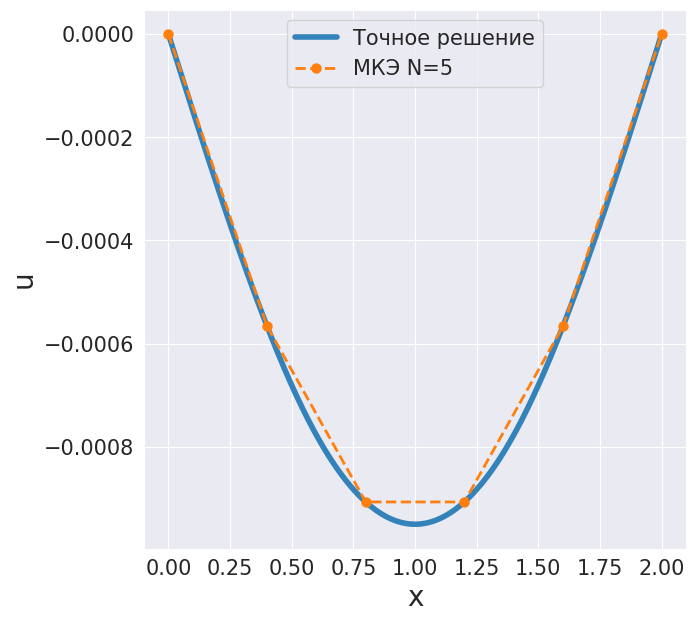

In [15]:
N = 5
returned = calculate(N)
plot_graphic(returned[4], returned[5])

In [ ]:
A x = b
QR x = b
R x = QT b
x = R-1 QT b